# AI 221: Machine Exercise 3

### Wine Quality Data Set

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from time import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, \
mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import scipy.stats as stats
import optuna
import logging

For this problem, we will only use the Red Portuguese "Vinho Verde" wine data. This data set contains information about 1599 wine samples with 11 attributes coming from physicochemical tests.

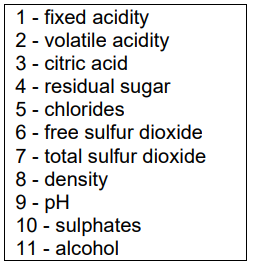

In [2]:
df = pd.read_csv("wine+quality/winequality-red.csv", delimiter=";")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.shape

(1599, 12)

The goal is to build a classifier that predicts the wine quality from the wine attributes. The wine quality is a
sensory preference score from 0 (poor) to 10 (excellent), graded by experts. ~~However, in the data set, some score values are actually empty.~~

In [4]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

### a.

**Split the samples into 70% Training and 30% Testing data at random with stratification 
(stratify=y)**

In [5]:
X = df.iloc[:, :11].to_numpy()
y = df.iloc[:, 11].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1119, 11) (1119,)
(480, 11) (480,)


In [6]:
pd.value_counts(y)

5    681
6    638
7    199
4     53
8     18
3     10
dtype: int64

**Build a pipeline with Standard scaler then SVC**

In [7]:
pipeline = make_pipeline(StandardScaler(),
                      SVC())

**Design hyper-parameter tuning procedure to automatically find the model with the best cross-validation accuracy. Report the accuracy, precision, recall, F1-score, and confusion matrix of the best SVC on test data.**

In [8]:
def evaluate(model):
      start = time()
      model.fit(X_train, y_train)
      print("Search took %.2f seconds for %d candidate parameter settings."
            % (time() - start, len(model.cv_results_["params"])))

      # Print best parameters after tuning
      print(model.best_params_)
      
      # Print how our model looks after hyper-parameter tuning
      print(model.best_estimator_)

      grid_predictions = model.predict(X_test)
      
      # print classification report
      print(classification_report(y_test, grid_predictions))

      cfm = confusion_matrix(y_test, grid_predictions)
      cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels=np.unique(y))
      cm_display.plot()
      plt.title("Test Data: Confusion Matrix")
      plt.show()
      return

Grid Search:

Search took 89.11 seconds for 60 candidate parameter settings.
{'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': 'rbf'}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, gamma=1))])
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        16
           5       0.69      0.77      0.73       204
           6       0.61      0.70      0.65       192
           7       0.72      0.38      0.50        60
           8       0.00      0.00      0.00         5

    accuracy                           0.65       480
   macro avg       0.34      0.31      0.31       480
weighted avg       0.63      0.65      0.63       480



c:\Users\BrenJay23\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\BrenJay23\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\BrenJay23\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


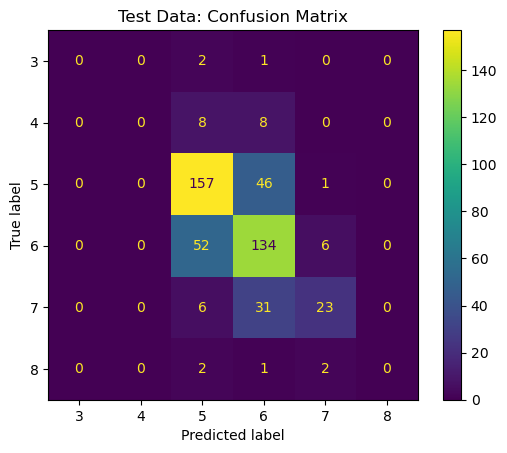

In [9]:
param_grid = {"svc__C": [0.1, 1, 10, 100], 
              "svc__gamma": [1, 0.1, 0.01, 0.001, 0.0001],
              "svc__kernel": ["rbf", "linear", "sigmoid"]}
grid_search = GridSearchCV(pipeline, param_grid, refit=True, cv=5)
evaluate(grid_search)

Random Search:

Search took 11.60 seconds for 20 candidate parameter settings.
{'svc__C': 0.915320046941642, 'svc__gamma': 0.3832055444335821, 'svc__kernel': 'rbf'}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.915320046941642, gamma=0.3832055444335821))])
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        16
           5       0.71      0.77      0.74       204
           6       0.59      0.69      0.64       192
           7       0.59      0.37      0.45        60
           8       0.00      0.00      0.00         5

    accuracy                           0.65       480
   macro avg       0.32      0.30      0.31       480
weighted avg       0.62      0.65      0.63       480



c:\Users\BrenJay23\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\BrenJay23\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\BrenJay23\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


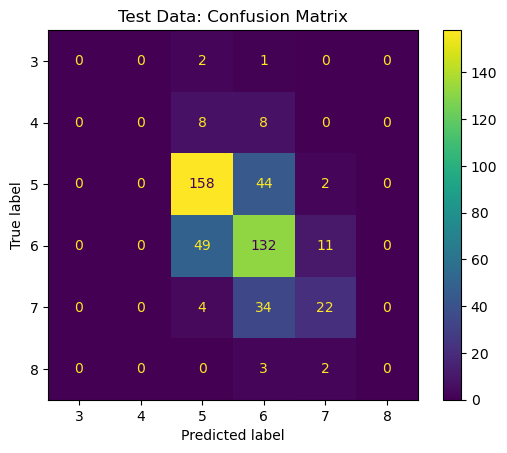

In [10]:
param_random = {"svc__C": stats.expon(scale=1), 
              "svc__gamma": stats.expon(scale=1),
              "svc__kernel": ["rbf", "linear", "sigmoid"]}
max_iter = 20
random_search = RandomizedSearchCV(pipeline, param_random, n_iter=max_iter, cv=5)
evaluate(random_search)

Grid search and random search were used for hyperparameter tuning. Both method yields similar results

### b.

**Treat it as a regression problem**

In [11]:
pipeline_b = make_pipeline(StandardScaler(),
                           SVR())

**Allow the model to predict continuous values from 0 to 10. Train an SVR (support vector regression) model with hyper-parameter tuning. Report the MSE, R2, and MAD (mean absolute deviation) on the test data**

Random Search:

In [12]:
param_random_b = {"svr__C": stats.expon(scale=10),
                "svr__epsilon": stats.expon(scale=0.01), 
                "svr__gamma": stats.expon(scale=0.1),
                "svr__kernel": ["rbf", "linear", "sigmoid"]}
max_iter_b = 20
random_search_b = RandomizedSearchCV(pipeline_b, param_random_b, n_iter=max_iter_b, random_state=0, cv=5)
random_search_b.fit(X_train, y_train)

# Print best parameters after tuning
print(random_search_b.best_params_)

# Print how our model looks after hyper-parameter tuning
print(random_search_b.best_estimator_)

{'svr__C': 1.621364934401004, 'svr__epsilon': 0.002514419355902303, 'svr__gamma': 0.04885570543174203, 'svr__kernel': 'rbf'}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr',
                 SVR(C=1.621364934401004, epsilon=0.002514419355902303,
                     gamma=0.04885570543174203))])


In [13]:
y_test_pred = random_search_b.predict(X_test)
svr_rmse = mean_squared_error(y_test, y_test_pred)
print(f"MSE: {svr_rmse}")
svr_r2 = r2_score(y_test, y_test_pred)
print(f"R2: {svr_r2}")
svr_mad = mean_absolute_error(y_test, y_test_pred)
print(f"MAD: {svr_mad}")

MSE: 0.3852098596006347
R2: 0.40584199730887893
MAD: 0.44750981375148674


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        16
           5       0.70      0.79      0.74       204
           6       0.62      0.69      0.65       192
           7       0.62      0.35      0.45        60
           8       0.00      0.00      0.00         5

    accuracy                           0.66       480
   macro avg       0.32      0.31      0.31       480
weighted avg       0.62      0.66      0.63       480



c:\Users\BrenJay23\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\BrenJay23\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\BrenJay23\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


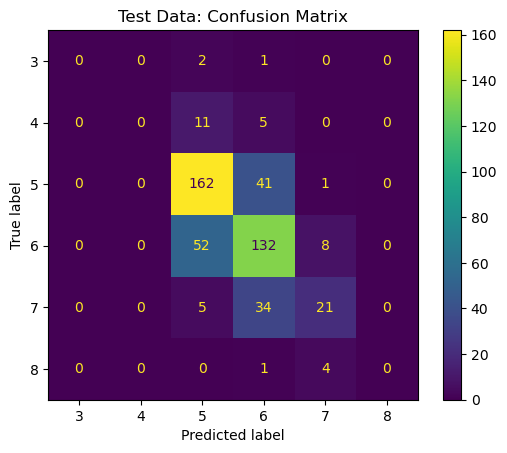

In [14]:
print(classification_report(y_test, np.round(y_test_pred)))

cfm = confusion_matrix(y_test, np.round(y_test_pred))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels=np.unique(y))
cm_display.plot()
plt.title("Test Data: Confusion Matrix")
plt.show()

Optuna:

In [15]:
def create_model(trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "sigmoid"])
    C = trial.suggest_float("C", 0.1, 1)
    epsilon = trial.suggest_float("epsilon", 0.001, 0.01)
    gamma = trial.suggest_float("gamma", 0.01, 0.1)

    model = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel=kernel)

    pipeline = make_pipeline(StandardScaler(), model)

    return pipeline

In [16]:
def objective(trial):
    pipeline = create_model(trial)
    scores = -cross_val_score(pipeline, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")
    return np.mean(scores)

In [17]:
start = time()

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("\n\nBest parameters: ", best_params)

best_model = create_model(study.best_trial)
best_model.fit(X_train, y_train)
scores = -cross_val_score(best_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
print("Best cross-validation score: %.5f" % np.mean(scores))
y_pred = best_model.predict(X_test)
best_mse = mean_squared_error(y_test, y_pred)
best_r2 = r2_score(y_test, y_pred)
best_mad = mean_absolute_error(y_test, y_pred)
print(f"Best MSE: {best_mse}")
print(f"Best R^2: {best_r2}")
print(f"Best MAD: {best_mad}")

total_time = time()-start
print("Runtime: %.4f sec" % total_time)



Best parameters:  {'kernel': 'rbf', 'C': 0.9975239484586497, 'epsilon': 0.004174691431058842, 'gamma': 0.09996106012935888}
Best cross-validation score: 0.41996
Best MSE: 0.39303692341762475
Best R^2: 0.3937693244825391
Best MAD: 0.44072158808126655
Runtime: 74.6450 sec


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        16
           5       0.72      0.79      0.75       204
           6       0.62      0.70      0.66       192
           7       0.59      0.33      0.43        60
           8       0.00      0.00      0.00         5

    accuracy                           0.66       480
   macro avg       0.32      0.30      0.31       480
weighted avg       0.62      0.66      0.63       480



c:\Users\BrenJay23\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\BrenJay23\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\BrenJay23\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


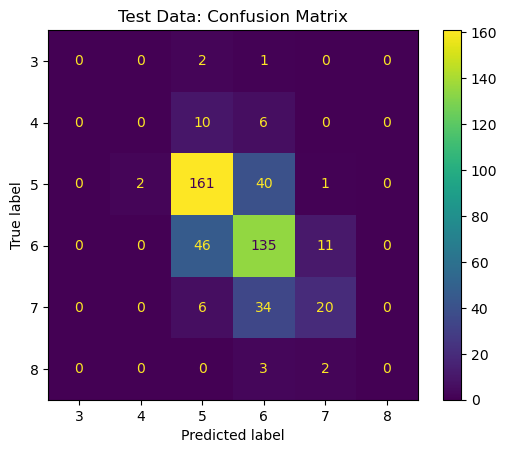

In [18]:
# print classification report
print(classification_report(y_test, np.round(y_pred)))

cfm = confusion_matrix(y_test, np.round(y_pred))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels=np.unique(y))
cm_display.plot()
plt.title("Test Data: Confusion Matrix")
plt.show()

**Were you able to improve against the result in the paper**

Random search and Optuna were used for hyperparameter tuning. The mean absolute deviation for both methods (0.45 for random & 0.44 for optuna) is better/lower than the one reported on the paper for SVM (0.46). The paper also used precision as metric and the conclusion stated that the overall accuracy is 62.4% for red wine (which is assumed to be weighted average based on the confusion matrx result). The precision for both random search and optuna is very close to the value in the paper. A major difference however is the way the training and testing is conducted. The paper used 5-fold cross validation and reported the prediction result using the entirety of the data. Random search and optuna also uses 5-fold cross validation with 70-30 split for training and testing. These two methods can be considered more robust than the one used in paper because the models are tested using data not seen during training. This is an improvement because it can probably provide a better generalization.

**Based on your results, discuss the difference of treating this problem as classification or regression. How will this decision impact the users of your model?**

- In classification, the model predicts one of the predefined classes for each input, resulting in categorical predictions, while in regression, the model predicts continuous values, which does not correspond to specific class labels.
- To classify multiple classes in regression problem, a way used in this problem is rounding-off the number to the nearest integer
- Rounding-off can be restrictive because of the inability to adjust the threshold which in turn impact the users of the model. A way to circumvent this can be by using ```np.modf``` which separates the integer and decimal component of the regression prediction (e.g. ```np.modf(y_pred)[1] + (np.modf(y_pred) > threshold)```).
- Classification metrics like accuracy, precision, recall, and the confusion matrix are used to evaluate the model's performance while mean squared error, R2, and mean absolute deviation are used for regression.
- In this particualr problem, Classification metrics have more interpretability because the model make it clear which class the input belongs to compared to regression where the metrics just tells how good the model is in fitting the data